###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('..')

from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [3]:
np.random.seed(1337)
random.seed(1337)

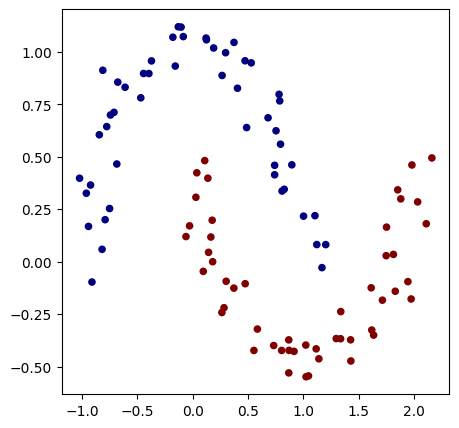

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs, make_swiss_roll
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

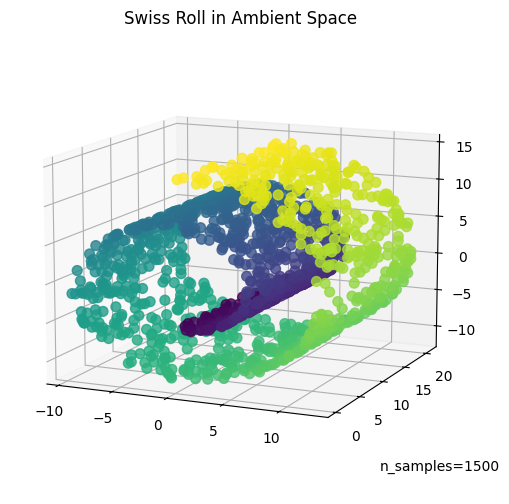

In [5]:
sr_points, sr_color = make_swiss_roll(n_samples=1500, random_state=0)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, s=50, alpha=0.8
)
ax.set_title("Swiss Roll in Ambient Space")
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)

In [6]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [7]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0) 0.5


In [8]:
def plot_model(model):
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.savefig('micrograd_demo.png')
    

step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.723590533697202, accuracy 81.0%
step 2 loss 0.7429006313851131, accuracy 77.0%
step 3 loss 0.7705641260584202, accuracy 82.0%
step 4 loss 0.3692793385976537, accuracy 84.0%
step 5 loss 0.31354548191852205, accuracy 86.0%
step 6 loss 0.2814234349772435, accuracy 89.0%
step 7 loss 0.26888733313983904, accuracy 91.0%
step 8 loss 0.2567147286057417, accuracy 91.0%
step 9 loss 0.2704862551637922, accuracy 91.0%


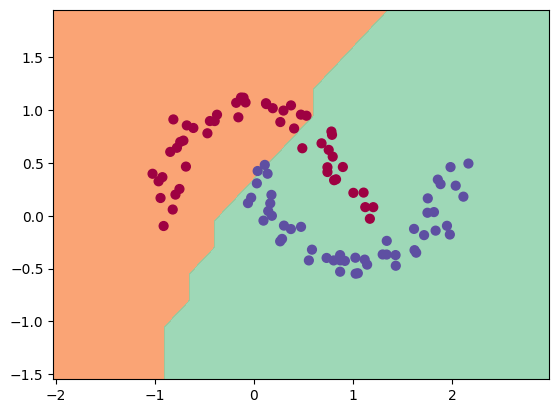

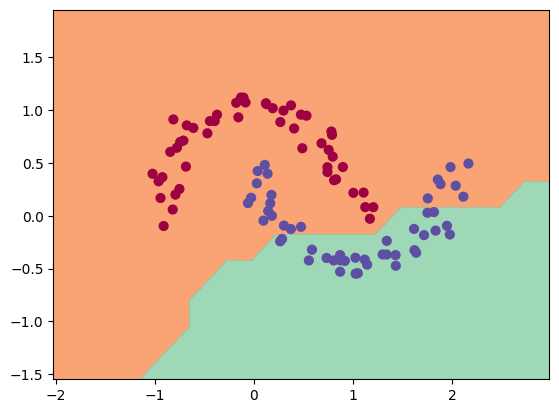

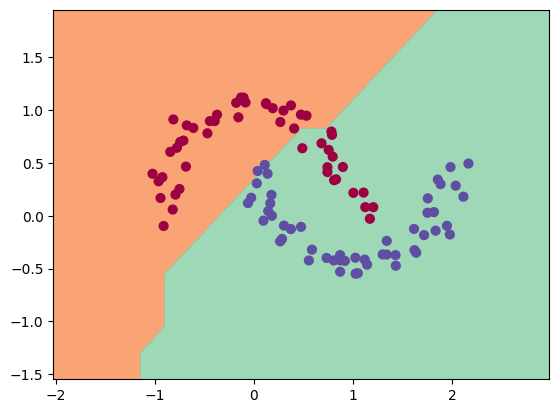

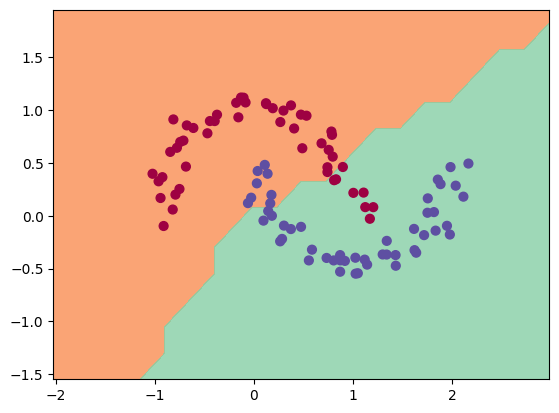

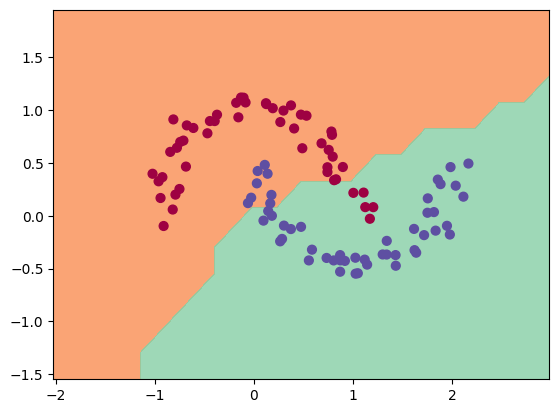

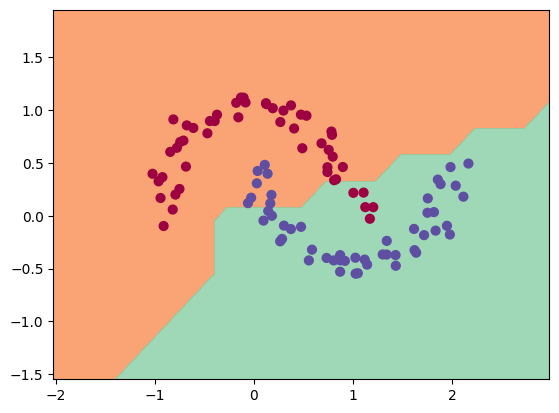

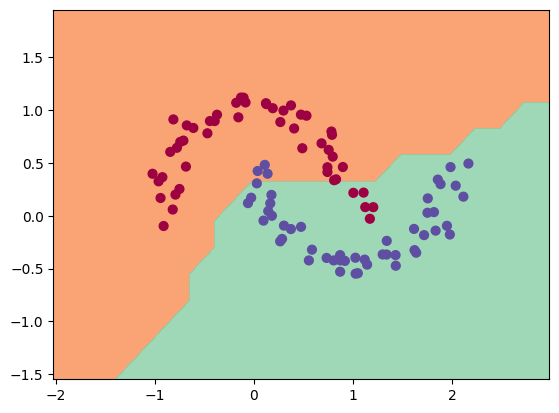

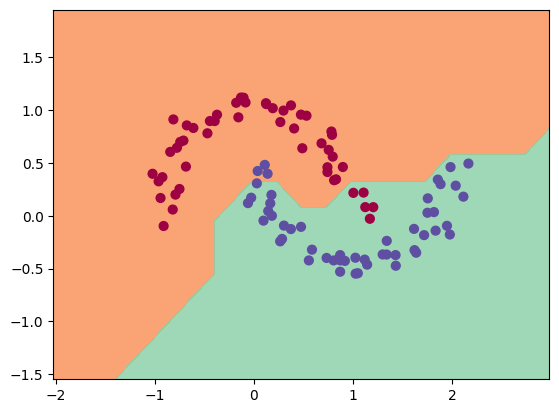

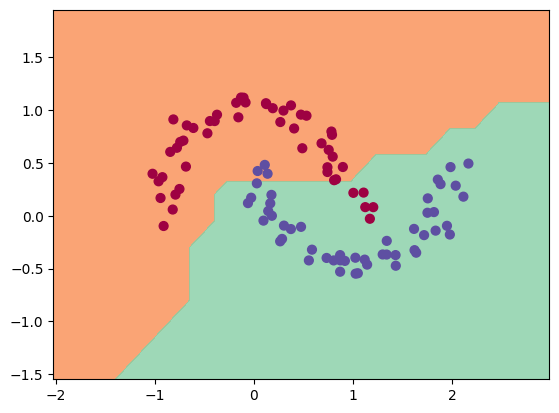

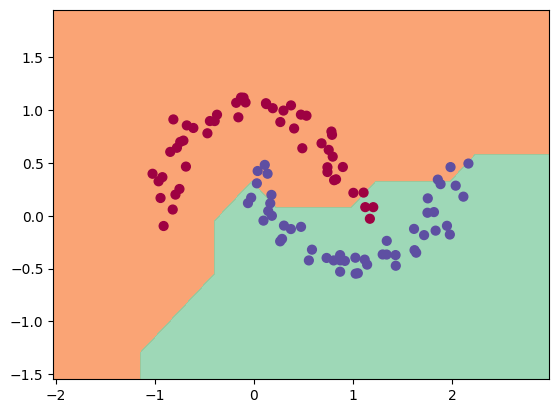

In [9]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        plot_model(model)
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


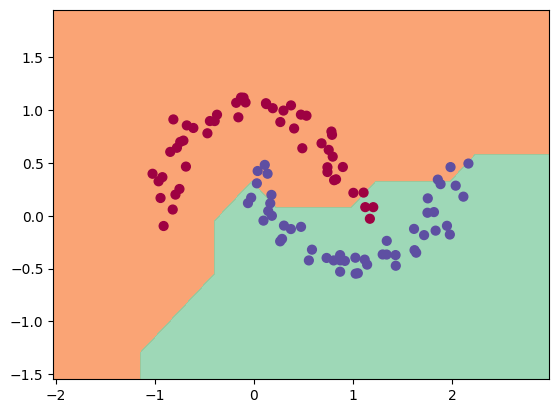

In [10]:
# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.savefig('micrograd_demo.png')


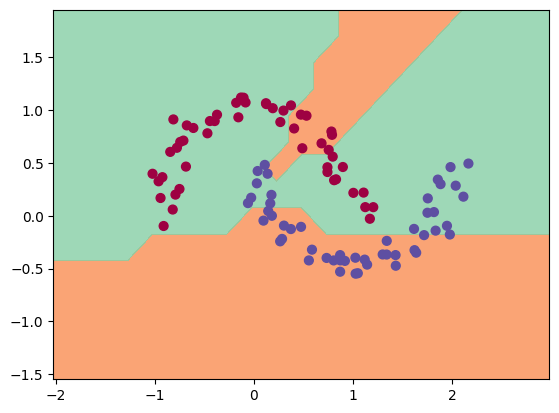

In [11]:
model2 = MLP(2, [16, 16, 1]) # 2-layer neural network
plot_model(model2)


step 0 loss 1.5968898068523196, accuracy 19.0%
step 0 loss 0.5997450178762416, accuracy 81.0%
step 1 loss 1.76611309409417, accuracy 50.0%
step 2 loss 2.7505859974703575, accuracy 50.0%
step 3 loss 0.7198882708082266, accuracy 51.0%
step 4 loss 0.41494524689952245, accuracy 80.0%
step 5 loss 0.28983674569563095, accuracy 86.0%
step 6 loss 0.7253122659056831, accuracy 68.0%
step 7 loss 0.7134949769302698, accuracy 81.0%
step 8 loss 0.5785607111914919, accuracy 79.0%
step 9 loss 0.4289719848852985, accuracy 82.0%
step 10 loss 0.3574500363494255, accuracy 85.0%
step 11 loss 0.3108719107811773, accuracy 85.0%
step 12 loss 0.25560625533084524, accuracy 87.0%
step 13 loss 0.19379349877240087, accuracy 92.0%
step 14 loss 0.18482143549902372, accuracy 92.0%
step 15 loss 0.2244412940563565, accuracy 90.0%
step 16 loss 0.33647795336340935, accuracy 84.0%
step 17 loss 0.18958329316565536, accuracy 92.0%
step 18 loss 0.15670005590186045, accuracy 94.0%
step 19 loss 0.1512266008841393, accuracy 94.

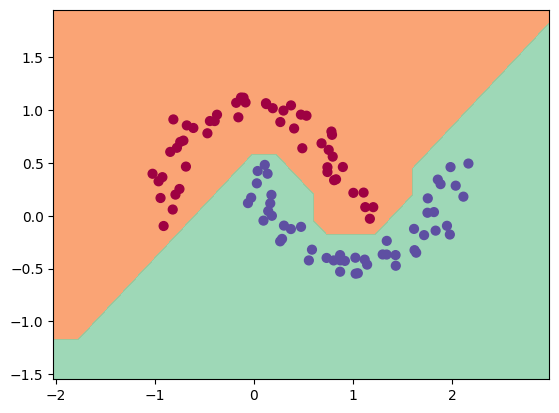

In [14]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

model = MLP(2, [16, 16, 1])
# optimization
fig, ax = plt.subplots()

def update(i):
    ax.clear()

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9*i/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    print(f"step {i} loss {total_loss.data}, accuracy {acc*100}%")

    # visualize decision boundary
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

ani = animation.FuncAnimation(fig, update, frames=100, repeat=False)
# save the animation
ani.save('nn-animation.gif', writer=PillowWriter(fps=30))
# plt.show()

In [4]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons

# Generate the dataset
X, y = make_moons(n_samples= 320, noise=0.1)

# Convert the numpy arrays to PyTorch tensors
X_torch = torch.from_numpy(X).float()
y_torch = torch.from_numpy(y).long()


# Create a TensorDataset from the tensors
dataset = TensorDataset(X_torch, y_torch)

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [5]:
# Get cpu, gpu or mps device for training.
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
device = 'cpu'
print(f"Using {device} device")

Using cpu device


In [7]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

torch_model = NeuralNetwork().to(device)
print(torch_model)



NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [11]:
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(torch_model.parameters(), lr=1e-3)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
train(dataloader, torch_model, loss_fn, optimizer)

/Users/brunozorrilla/Documents/GitHub/visual-ml/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: Found dtype Long but expected Float